In [1]:
# import cudf as pd
import pandas as pd
from pandarallel import pandarallel

pandarallel.initialize()

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# df = pd.read_csv("llamacpp.llama8b.trace.3conversation_no_cachedrop.log)
# df = pd.read_csv("results/retval/llamacpp.llama8b.trace.1717683027-1talk.log")
# df = pd.read_csv("results/retval/llamacpp.llama8b.trace.1717683171-3talk.log")
df = pd.read_csv("results/retval/no_prefetch/llamacpp.llama70b.trace-only_load_model_time.1718678162.log")
df = df.dropna()

/tmp/ipykernel_3675004/4047565257.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("results/retval/no_prefetch/llamacpp.llama70b.trace-only_load_model_time.1718678162.log")


In [4]:
df['time'] = df["time"].astype("int")
df["flags"] = df["flags"].astype("int").parallel_apply(lambda x: f"{bin(x)[2:]}".ljust(10, "0")).astype("str")
df["retval"] = df["retval"].astype("int").parallel_apply(lambda x: f"{hex(x)}").astype("str")

In [5]:
df

,pid,name,addr,flags,time,retval
0,3673956,bpftrace,0x55b81f313c60,1001010101,5020,0x0
1,3673963,bpftrace,0x7fd481eeb080,1101010100,22980,0x100
2,3673963,bpftrace,0x7fffffffefea,1000000100,11460,0x0
3,3673963,sudo,0x5592063cc278,1000010101,6590,0x200
4,3673963,sudo,0x7fb7803b4110,1000010101,4180,0x200
...,...,...,...,...,...,...
1233677,1023,systemd-journal,0x7f721a130c10,1001010101,2260,0x4000
1233678,2888268,node,0x28bf237a0000,1001010101,8630,0x0
1233679,3673956,bpftrace,0x55b8204c18c0,1001010100,22230,0x0
1233680,3673956,bpftrace,0x55b8205444f0,1001010100,14880,0x0


In [6]:
df["name"].value_counts()

name
main               1106460
node                 43094
loginctl             41119
btop                 17659
ps                   10399
cpuUsage.sh           5169
cat                   2288
systemd-journal       2156
sh                    1177
rustdesk               825
sudo                   634
sed                    601
cpptools               586
which                  404
sleep                  349
cuda-EvtHandlr         215
git                    194
bash                   111
bpftrace               107
systemd-logind          87
zsh                     30
gmain                    9
in:imklog                3
systemd                  3
sshd                     2
Name: count, dtype: int64

In [7]:
# 过滤掉其他附带的程序
df = df[df["name"] == "main"]
df = df.reset_index().drop(columns=["index"])

In [8]:
df["name"].value_counts()

name
main    1106460
Name: count, dtype: int64

In [9]:
df["retval"].value_counts()

retval
0x100    788165
0x400    191439
0x0       62210
0x200     44660
0x404     19917
0x300        69
Name: count, dtype: int64

# 虚拟地址转换成pfn

In [10]:
df["pfn"] = df["addr"].apply(lambda x: int(x, 16))
df["pfn"] = df["pfn"].parallel_apply(lambda x: (x - df["pfn"].min()) // (4 * 1024))
df["pfn"] = df["pfn"].astype("int")

In [11]:
df

,pid,name,addr,flags,time,retval,pfn
0,3673968,main,0x5618a64e5468,1000010101,369875,0x404,23109176037
1,3673968,main,0x5618a64e5468,1000110101,2840,0x200,23109176037
2,3673968,main,0x7f4b9b6e0110,1000010101,5350,0x200,34168462560
3,3673968,main,0x7ffe9a600199,1000010101,1290,0x0,34356153344
4,3673968,main,0x7ffe9a5fff90,1000010101,1940,0x0,34356153343
...,...,...,...,...,...,...,...
1106455,3673968,main,0x5618a89b6000,1001010101,1130,0x0,23109185462
1106456,3673968,main,0x5618a89b7000,1001010101,1180,0x0,23109185463
1106457,3673968,main,0x5618a873ba40,1001010100,16710,0x0,23109184827
1106458,3673968,main,0x7ffe9a5fa380,1001010101,2640,0x0,34356153338


# Plot

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
bin(2)[2:]

'10'

<Axes: ylabel='pfn'>

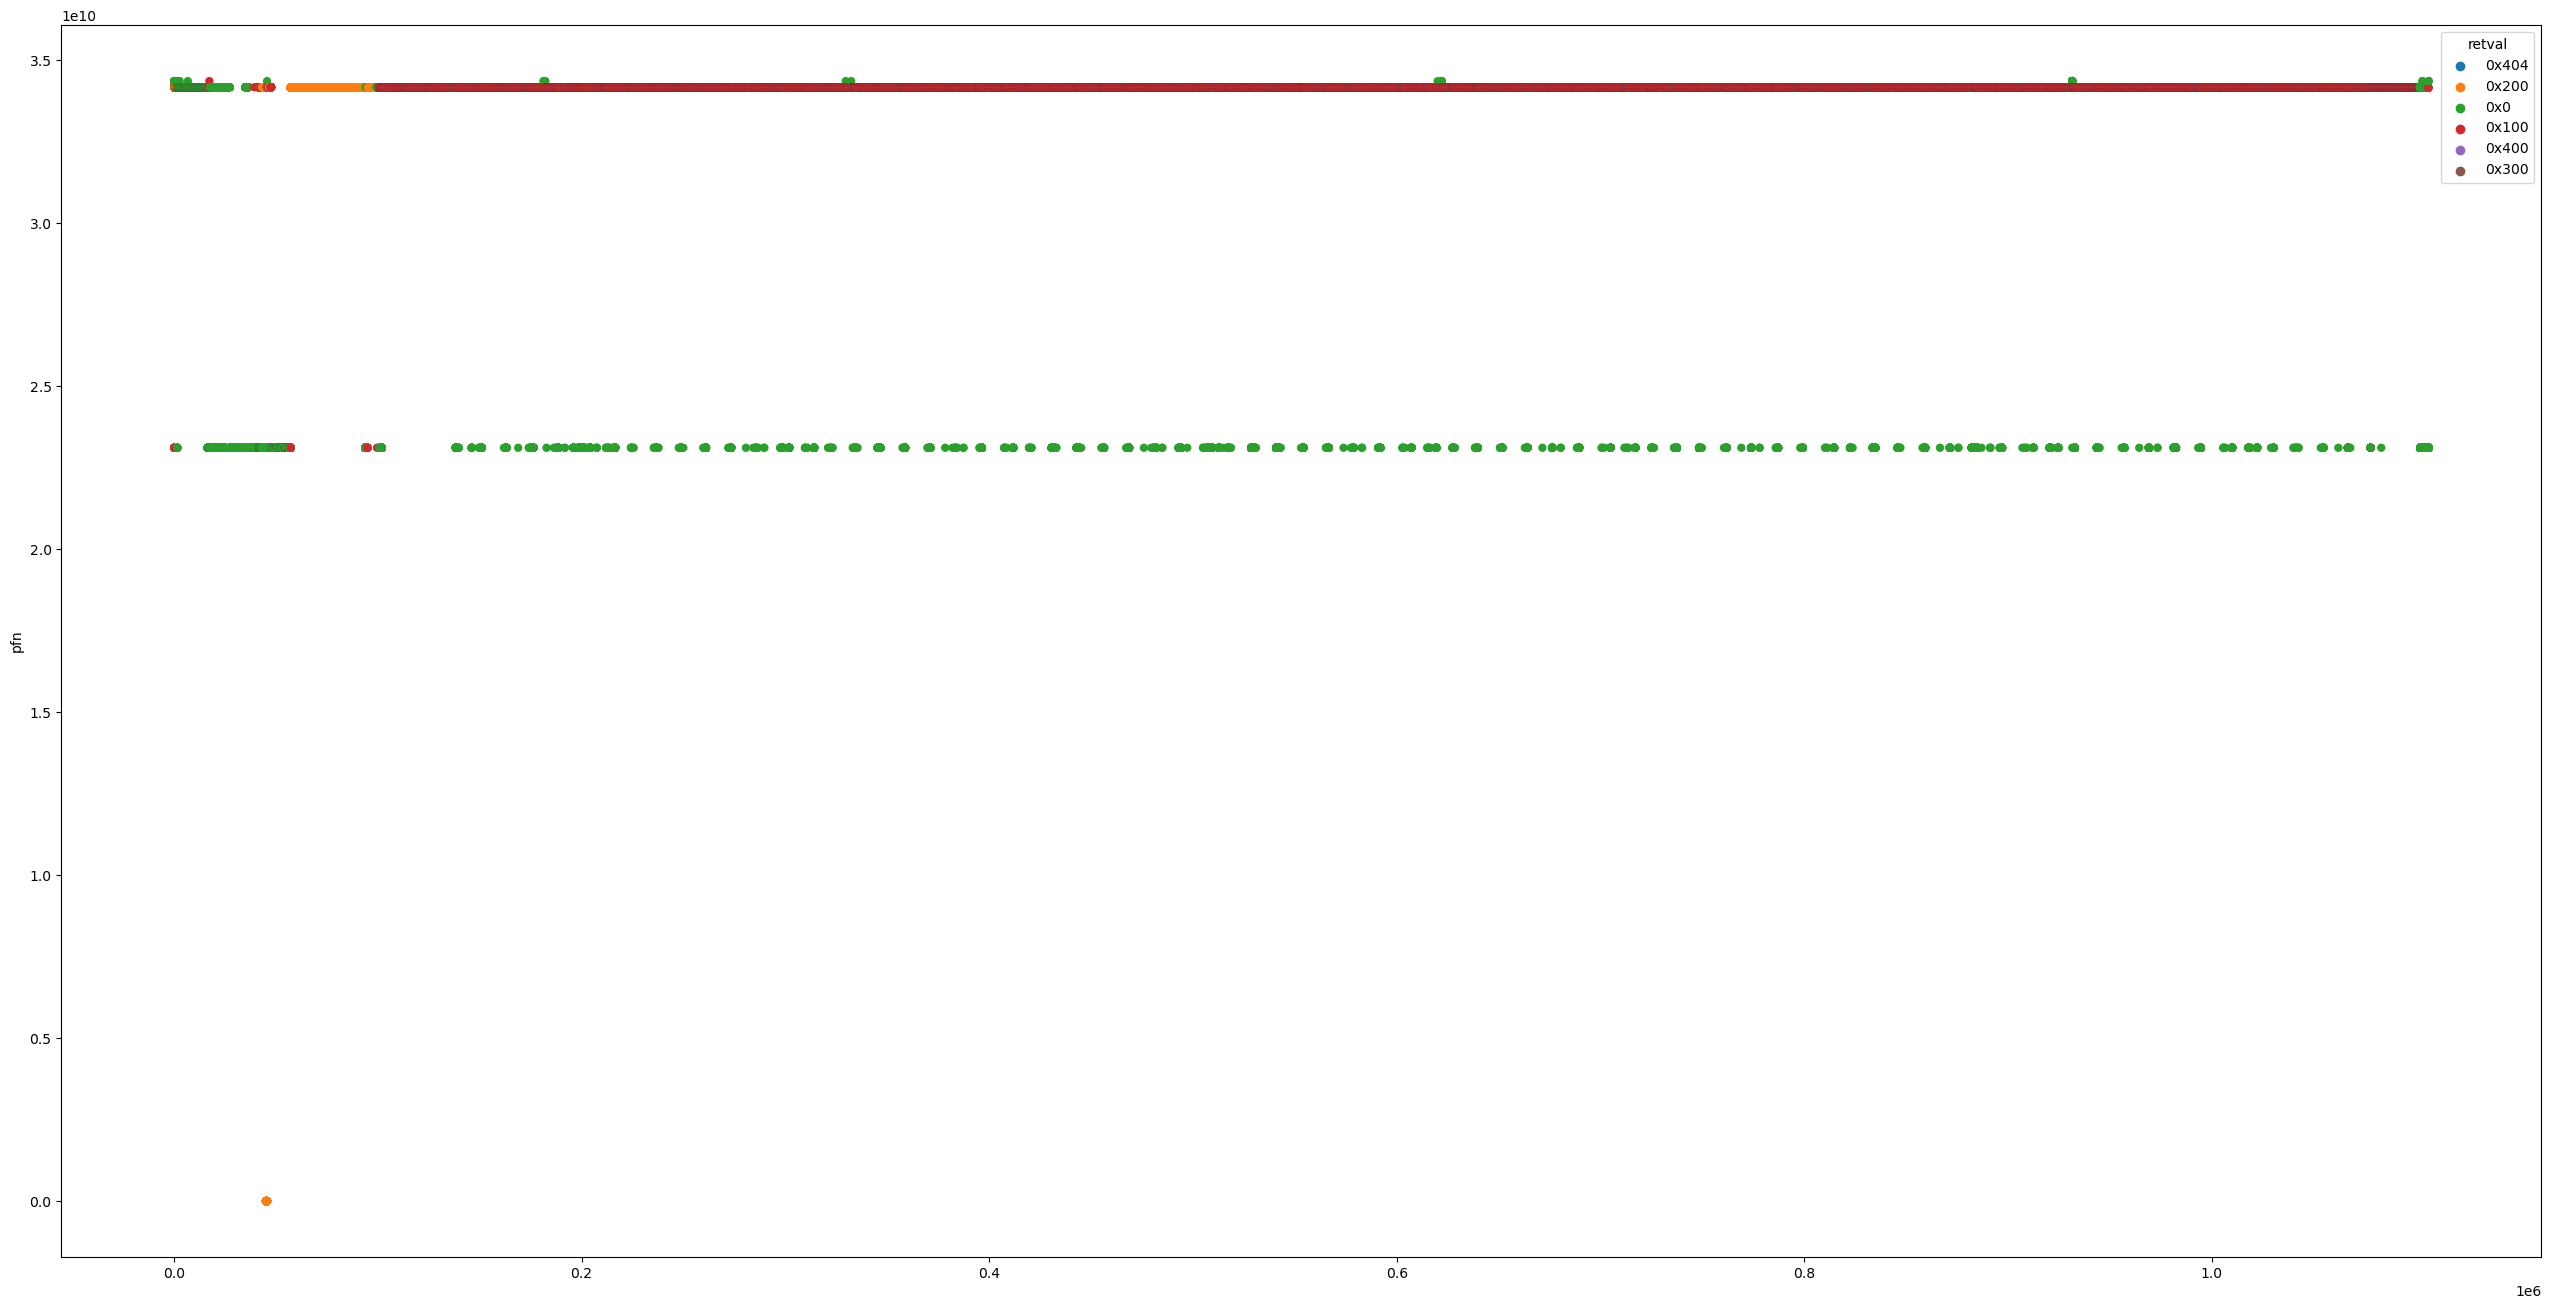

In [14]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(df)), y=df['pfn'], hue=df["retval"], linewidth=0)

In [15]:
kernel_fault = df[df["pfn"] > 3e10]
user_fault = df[(1e10 < df["pfn"]) & (df["pfn"] <= 3e10)]

<Axes: ylabel='pfn'>

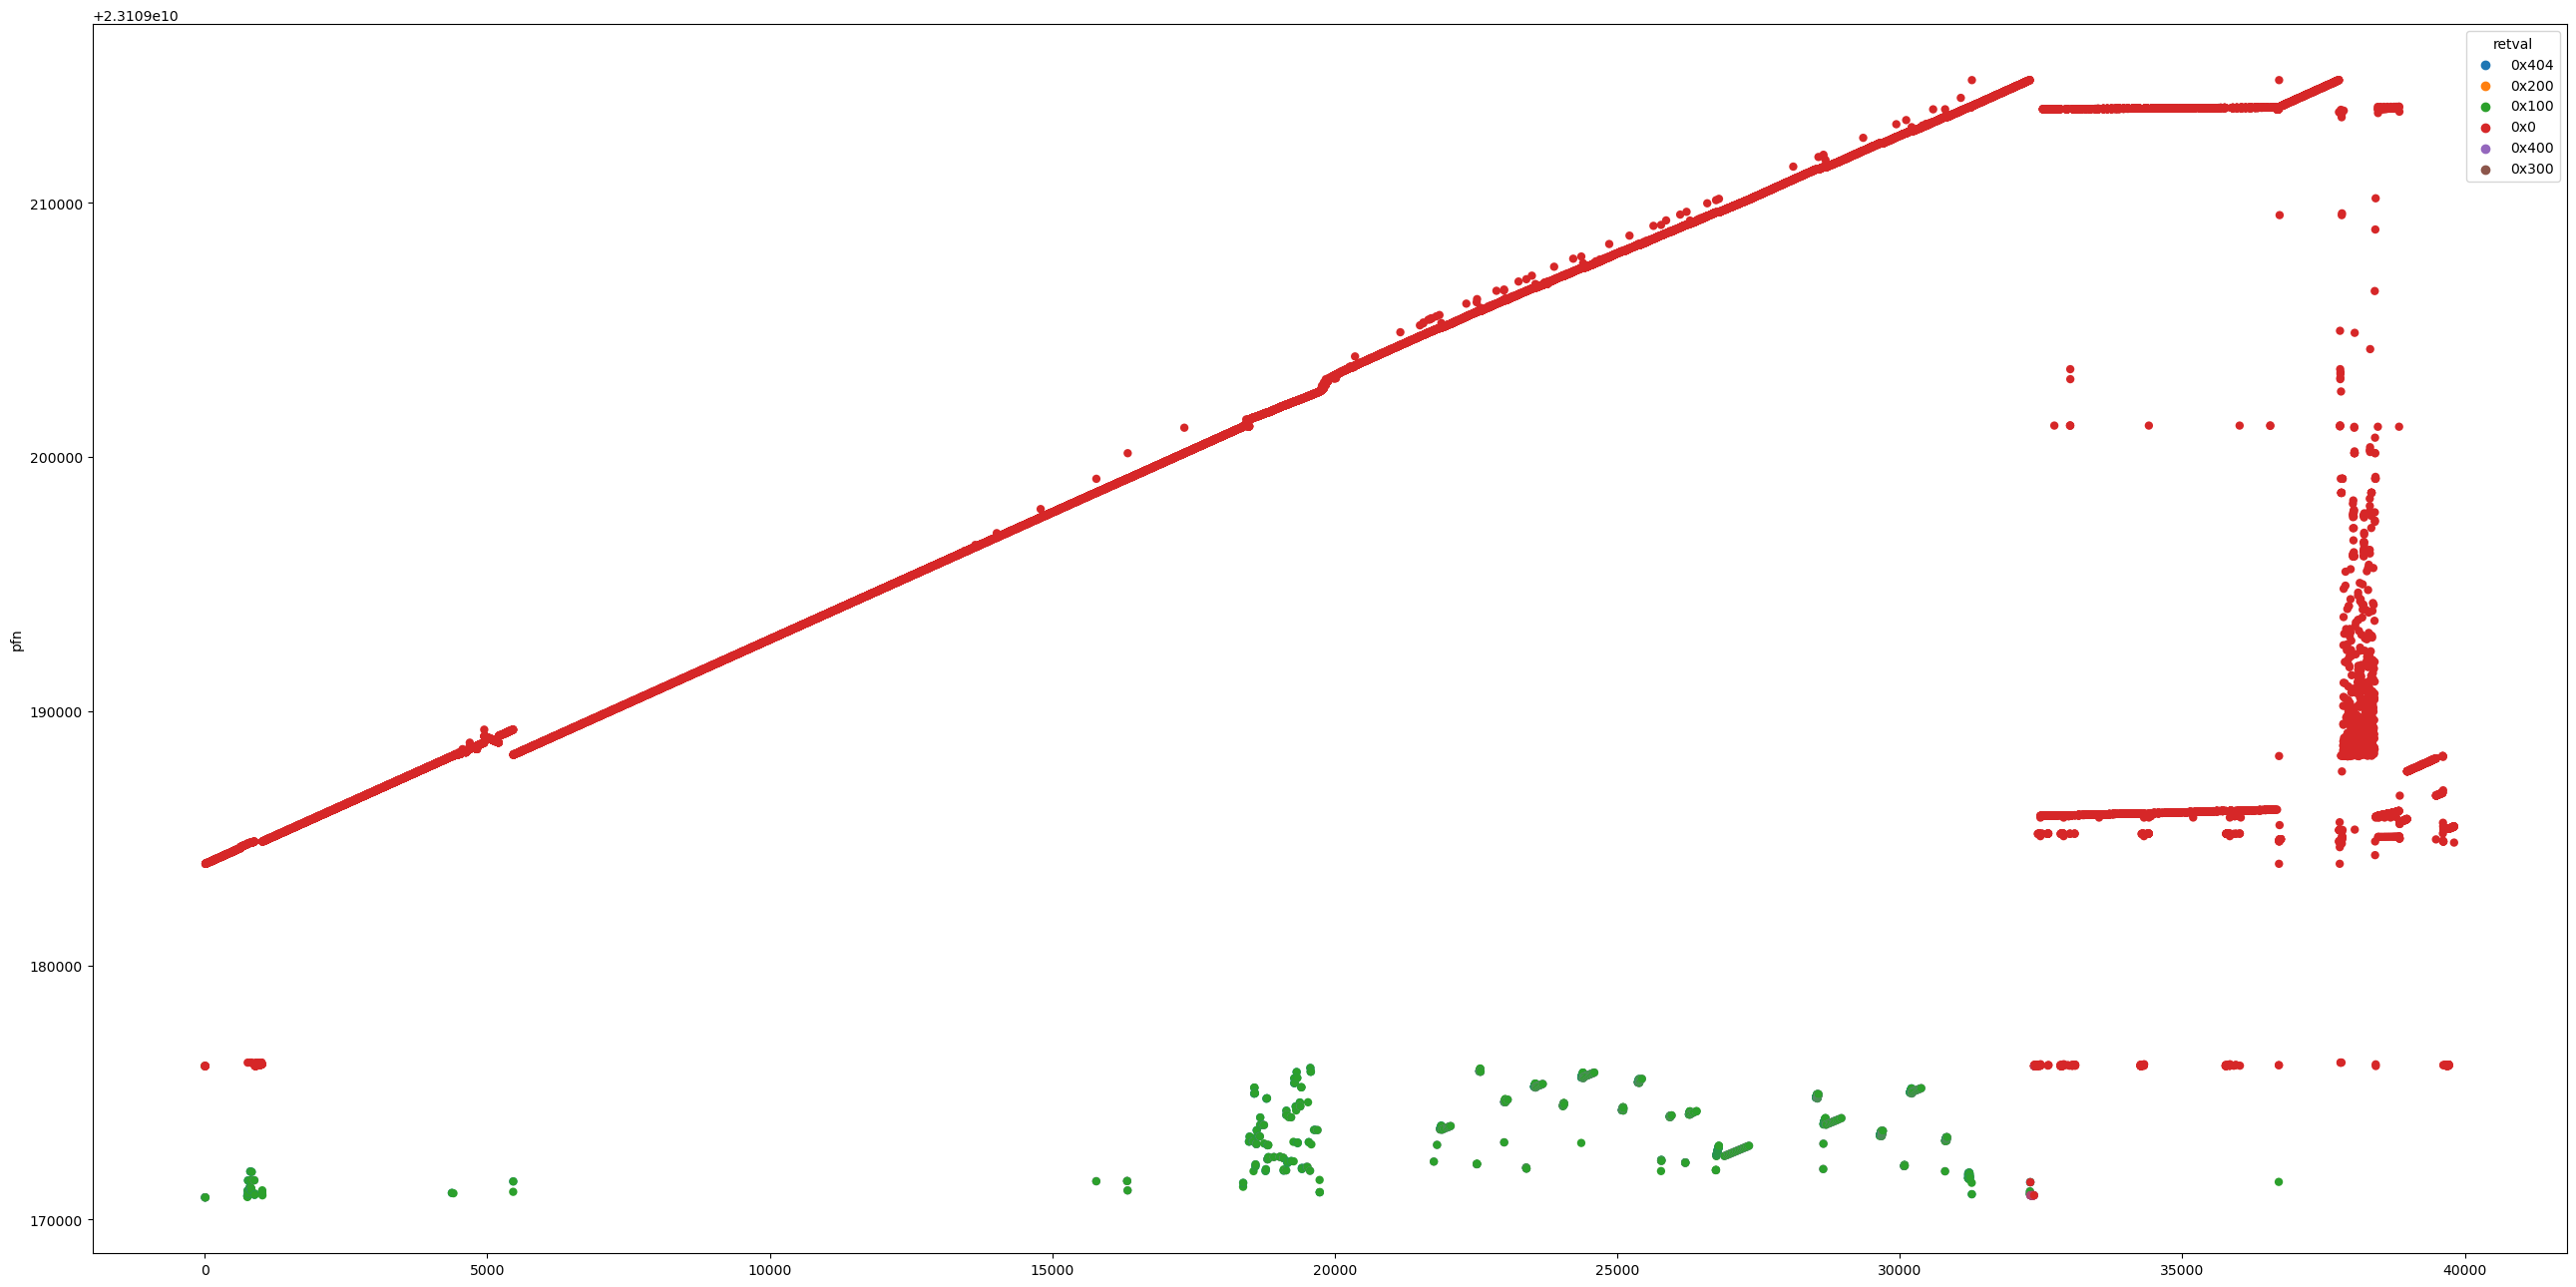

In [16]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(user_fault)), y=user_fault['pfn'], hue=user_fault["retval"], linewidth=0)

### 去除一下所有的0x0的fault，也就是非错误处理逻辑

In [17]:
no_zero_retval_fault = user_fault[user_fault["retval"] != "0x0"]

<Axes: ylabel='pfn'>

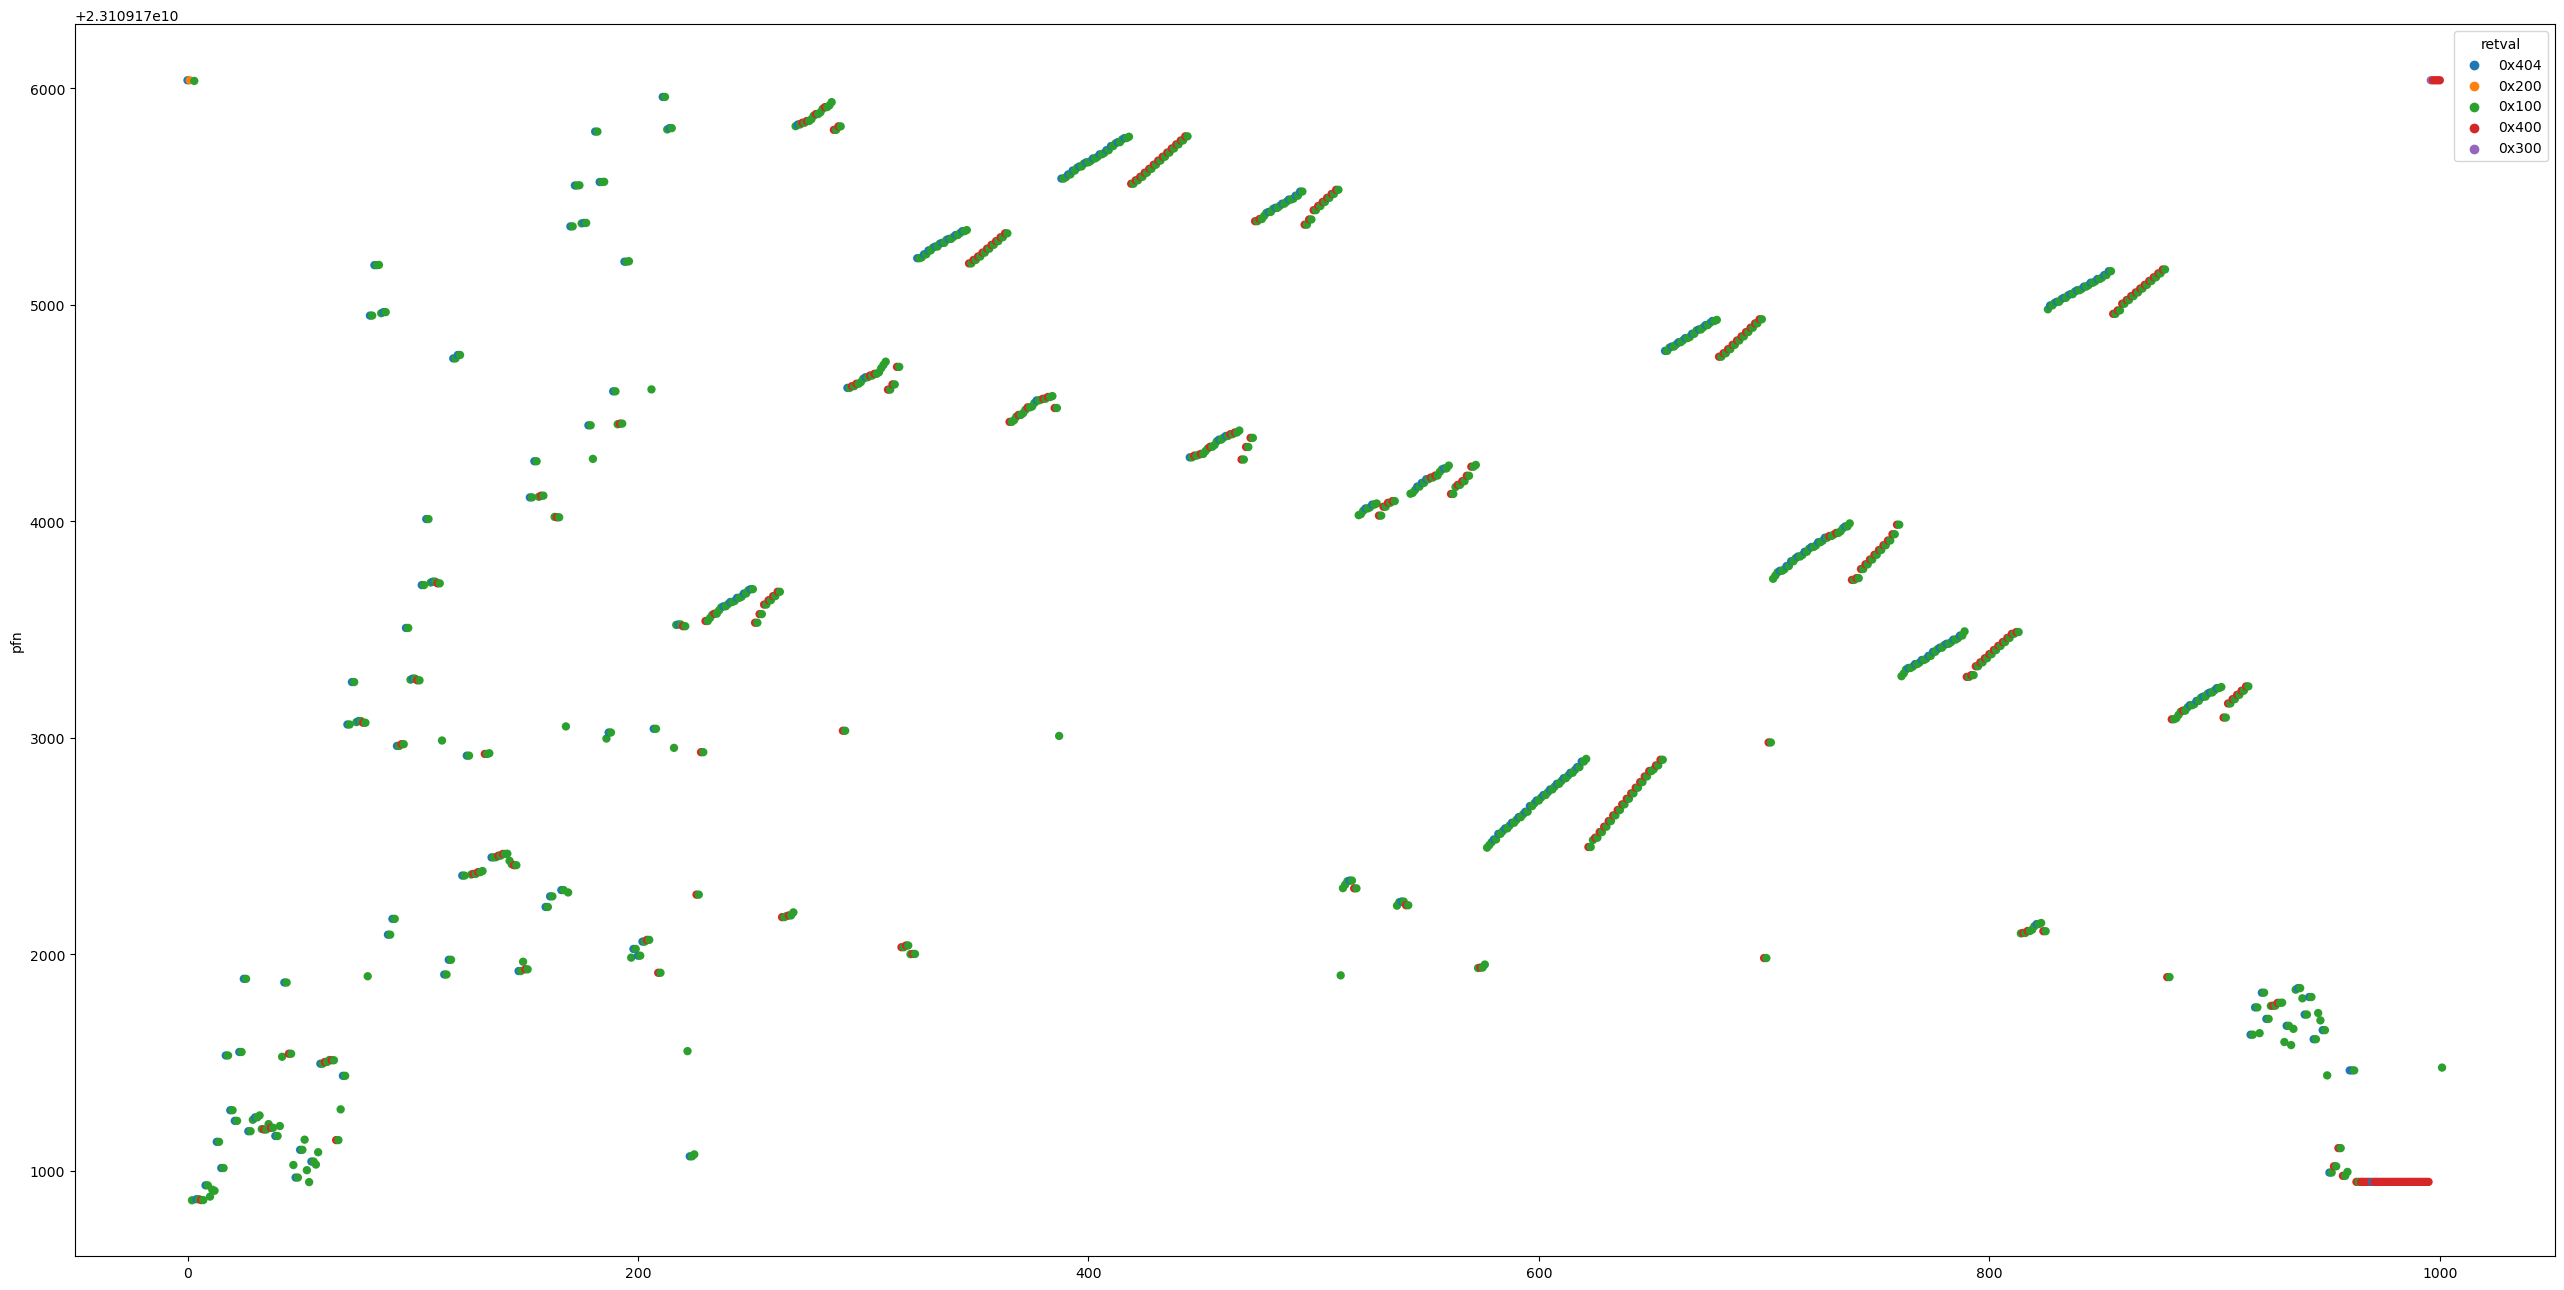

In [18]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(no_zero_retval_fault)), y=no_zero_retval_fault['pfn'], hue=no_zero_retval_fault["retval"], linewidth=0)

### 去除一下所有的0x100的fault，也就是NOPAGE

In [19]:
drop_zero_drop_no_page_retval_fault = user_fault[(user_fault["retval"] != "0x0") & (user_fault["retval"] != "0x100")]

<Axes: ylabel='pfn'>

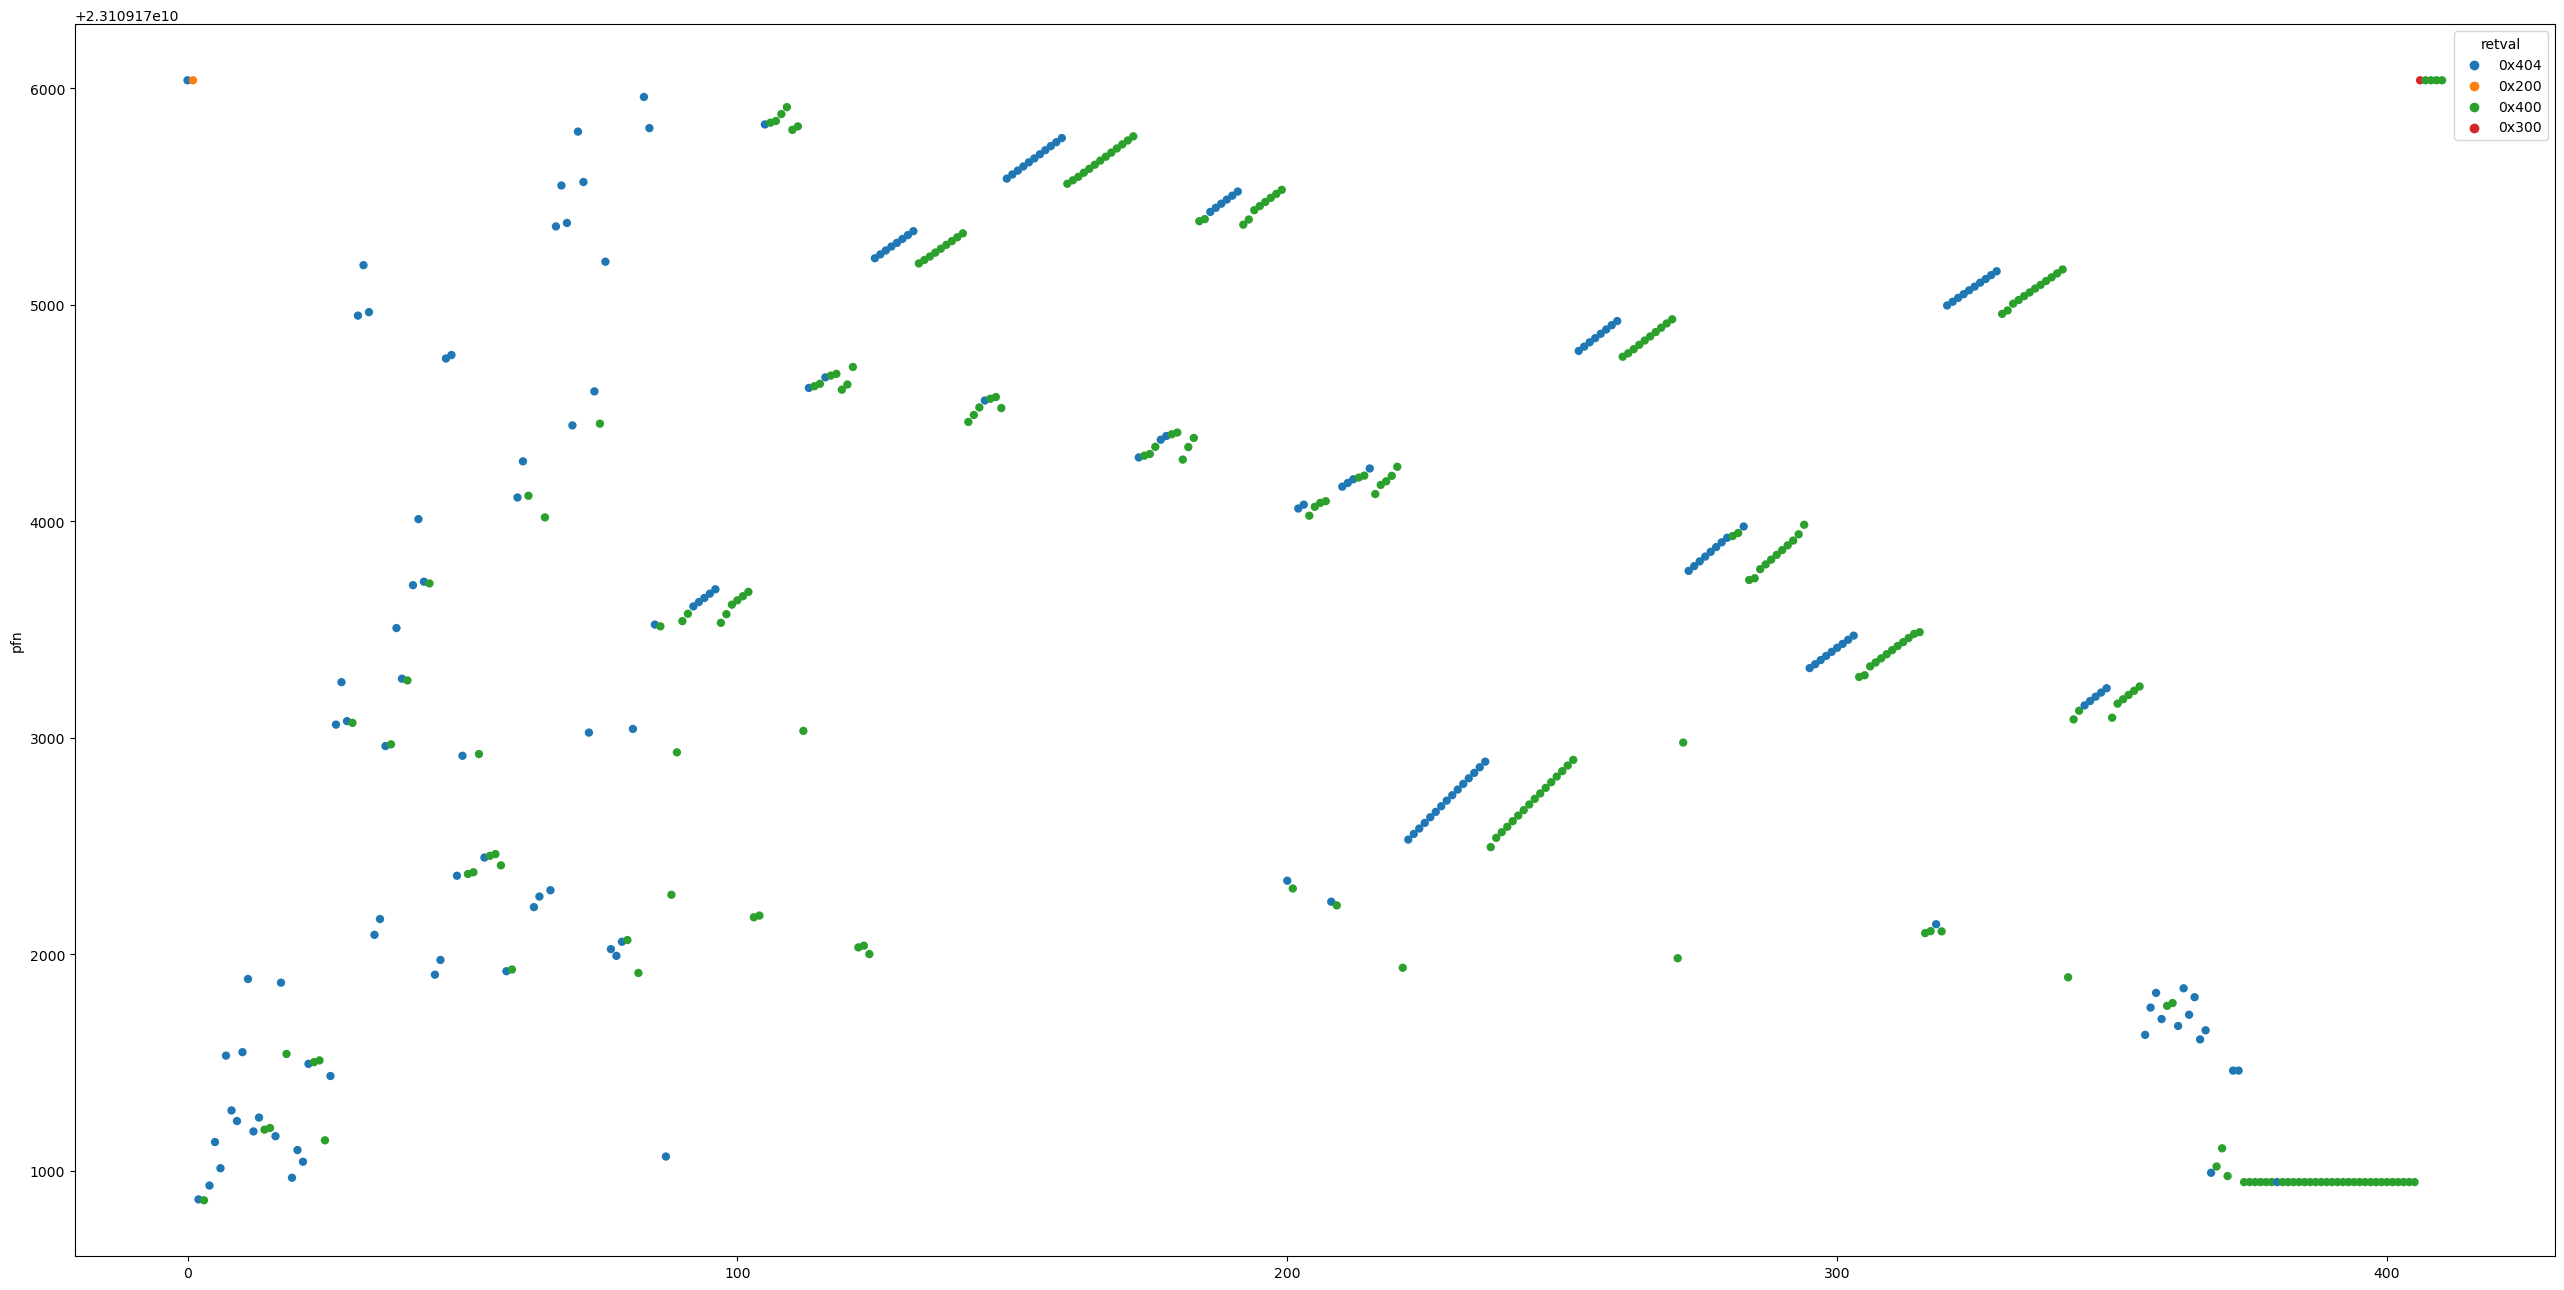

In [20]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(drop_zero_drop_no_page_retval_fault)), y=drop_zero_drop_no_page_retval_fault['pfn'], hue=drop_zero_drop_no_page_retval_fault["retval"], linewidth=0)

In [28]:
bak_df = df
bak_df["count"] = 1
time_cost = bak_df.groupby("retval").sum(["time", "count"])
time_cost["time"] = time_cost["time"].apply(lambda x: x/1e9)
time_cost

,time,pfn,count
retval,,,
0x0,0.309942,1696409626977693,62210
0x100,5.262210,26919789748417538,788165
0x200,0.069581,1508046837103328,44660
0x300,0.000761,2346233303014,69
0x400,363.276690,6537648714189866,191439
0x404,83.842139,678460922408570,19917


In [22]:
df["time"].sum()

452761322346

### 只统计 major fault

In [23]:
fault_major_df = df[(df["retval"] == '0x404') | (df["retval"] == '0x400')]

<Axes: ylabel='pfn'>

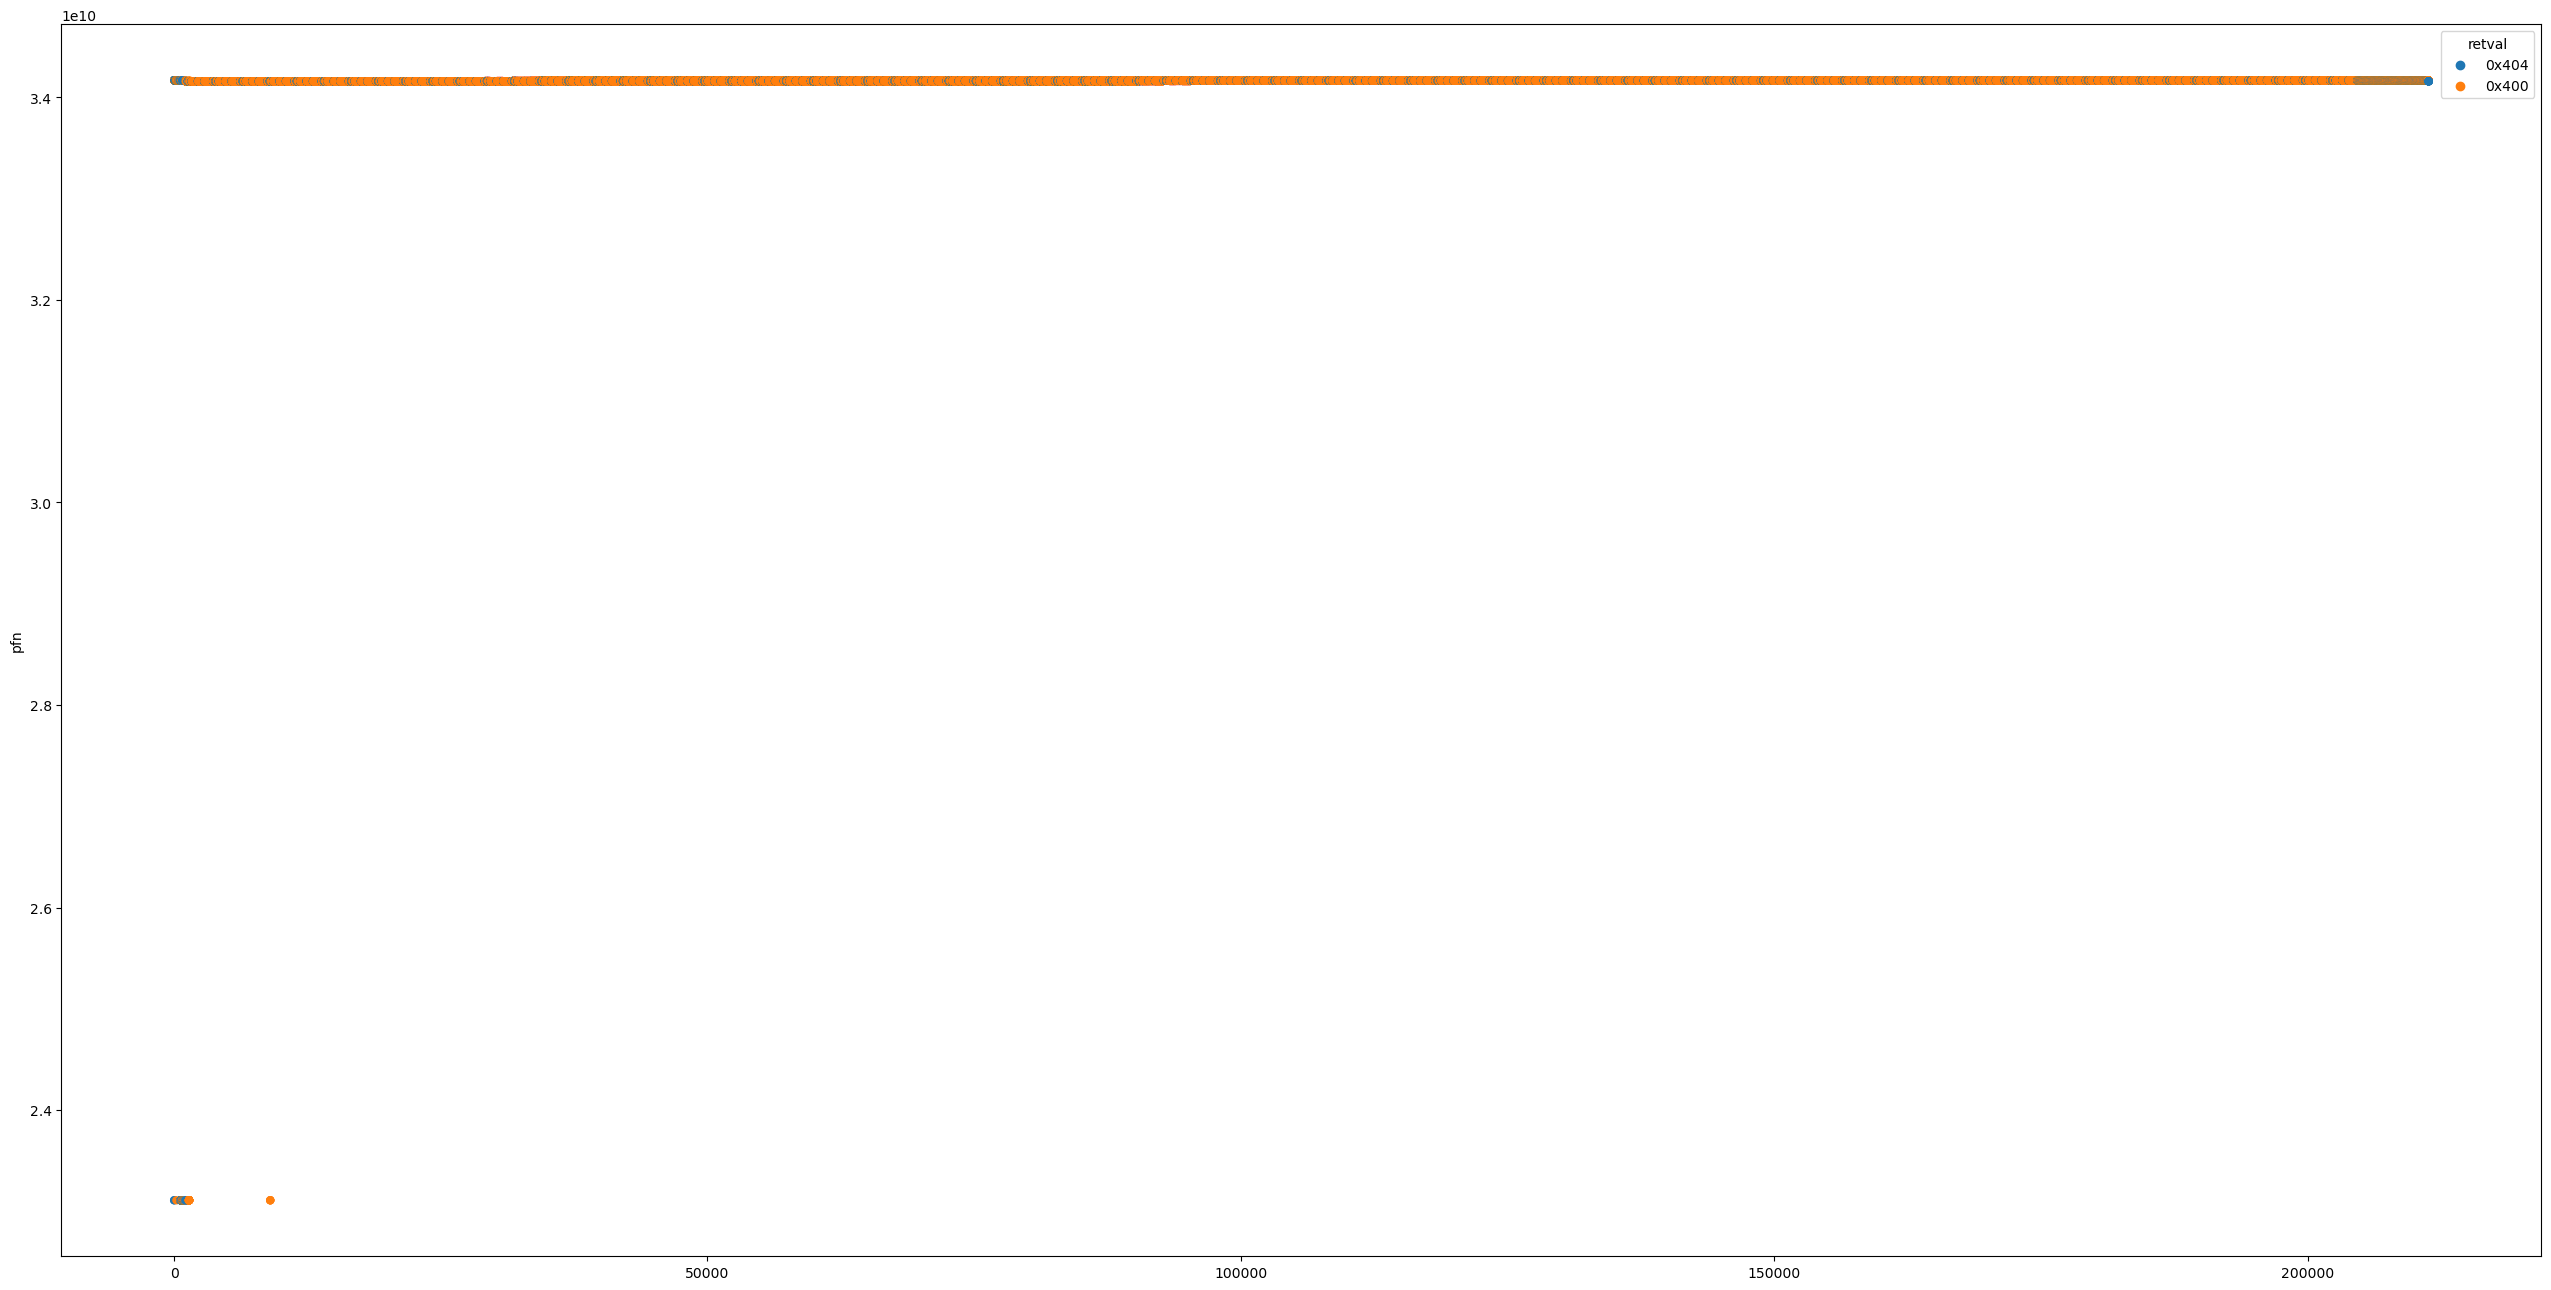

In [24]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(fault_major_df)), y=fault_major_df['pfn'], hue=fault_major_df["retval"], linewidth=0)

In [25]:
kernel_fault_major_df = fault_major_df[fault_major_df["pfn"] > 3e10]
user_fault_major_df = fault_major_df[fault_major_df["pfn"] <= 3e10]


In [26]:
print(len(kernel_fault_major_df))
print(len(user_fault_major_df))

210947
409


In [27]:
kernel_fault_major_df["time"].sum() / 1e9

447.057399644

In [30]:
user_fault_major_df["retval"].value_counts()

retval
0x400    230
0x404    179
Name: count, dtype: int64

In [31]:
kernel_fault_major_df["retval"].value_counts()

retval
0x400    191209
0x404     19738
Name: count, dtype: int64

In [32]:
kernel_fault["addr"]

2          0x7f4b9b6e0110
3          0x7ffe9a600199
4          0x7ffe9a5fff90
5          0x7f4b9b6c5290
6          0x7f4b9b6dfe0e
                ...      
1106268    0x7f41f8798fa0
1106269    0x7f41f6a9a3a0
1106270    0x7f41f6a9a3a0
1106458    0x7ffe9a5fa380
1106459    0x7ffe9a5f9ce8
Name: addr, Length: 1066137, dtype: object

### 真内核用户态划分
addr >= 0xFFFF 8000 0000 0000 内核态

addr <= 0x0000 7FFF FFFF F000 用户态

In [35]:
df[df["addr"] <= "0xFFFF800000000000"]

,pid,name,addr,flags,time,retval,pfn,count
0,3673968,main,0x5618a64e5468,1000010101,369875,0x404,23109176037,1
1,3673968,main,0x5618a64e5468,1000110101,2840,0x200,23109176037,1
2,3673968,main,0x7f4b9b6e0110,1000010101,5350,0x200,34168462560,1
3,3673968,main,0x7ffe9a600199,1000010101,1290,0x0,34356153344,1
4,3673968,main,0x7ffe9a5fff90,1000010101,1940,0x0,34356153343,1
...,...,...,...,...,...,...,...,...
1106455,3673968,main,0x5618a89b6000,1001010101,1130,0x0,23109185462,1
1106456,3673968,main,0x5618a89b7000,1001010101,1180,0x0,23109185463,1
1106457,3673968,main,0x5618a873ba40,1001010100,16710,0x0,23109184827,1
1106458,3673968,main,0x7ffe9a5fa380,1001010101,2640,0x0,34356153338,1


In [42]:
df["addr"].min()

'0x205a00000'

<Axes: ylabel='pfn'>

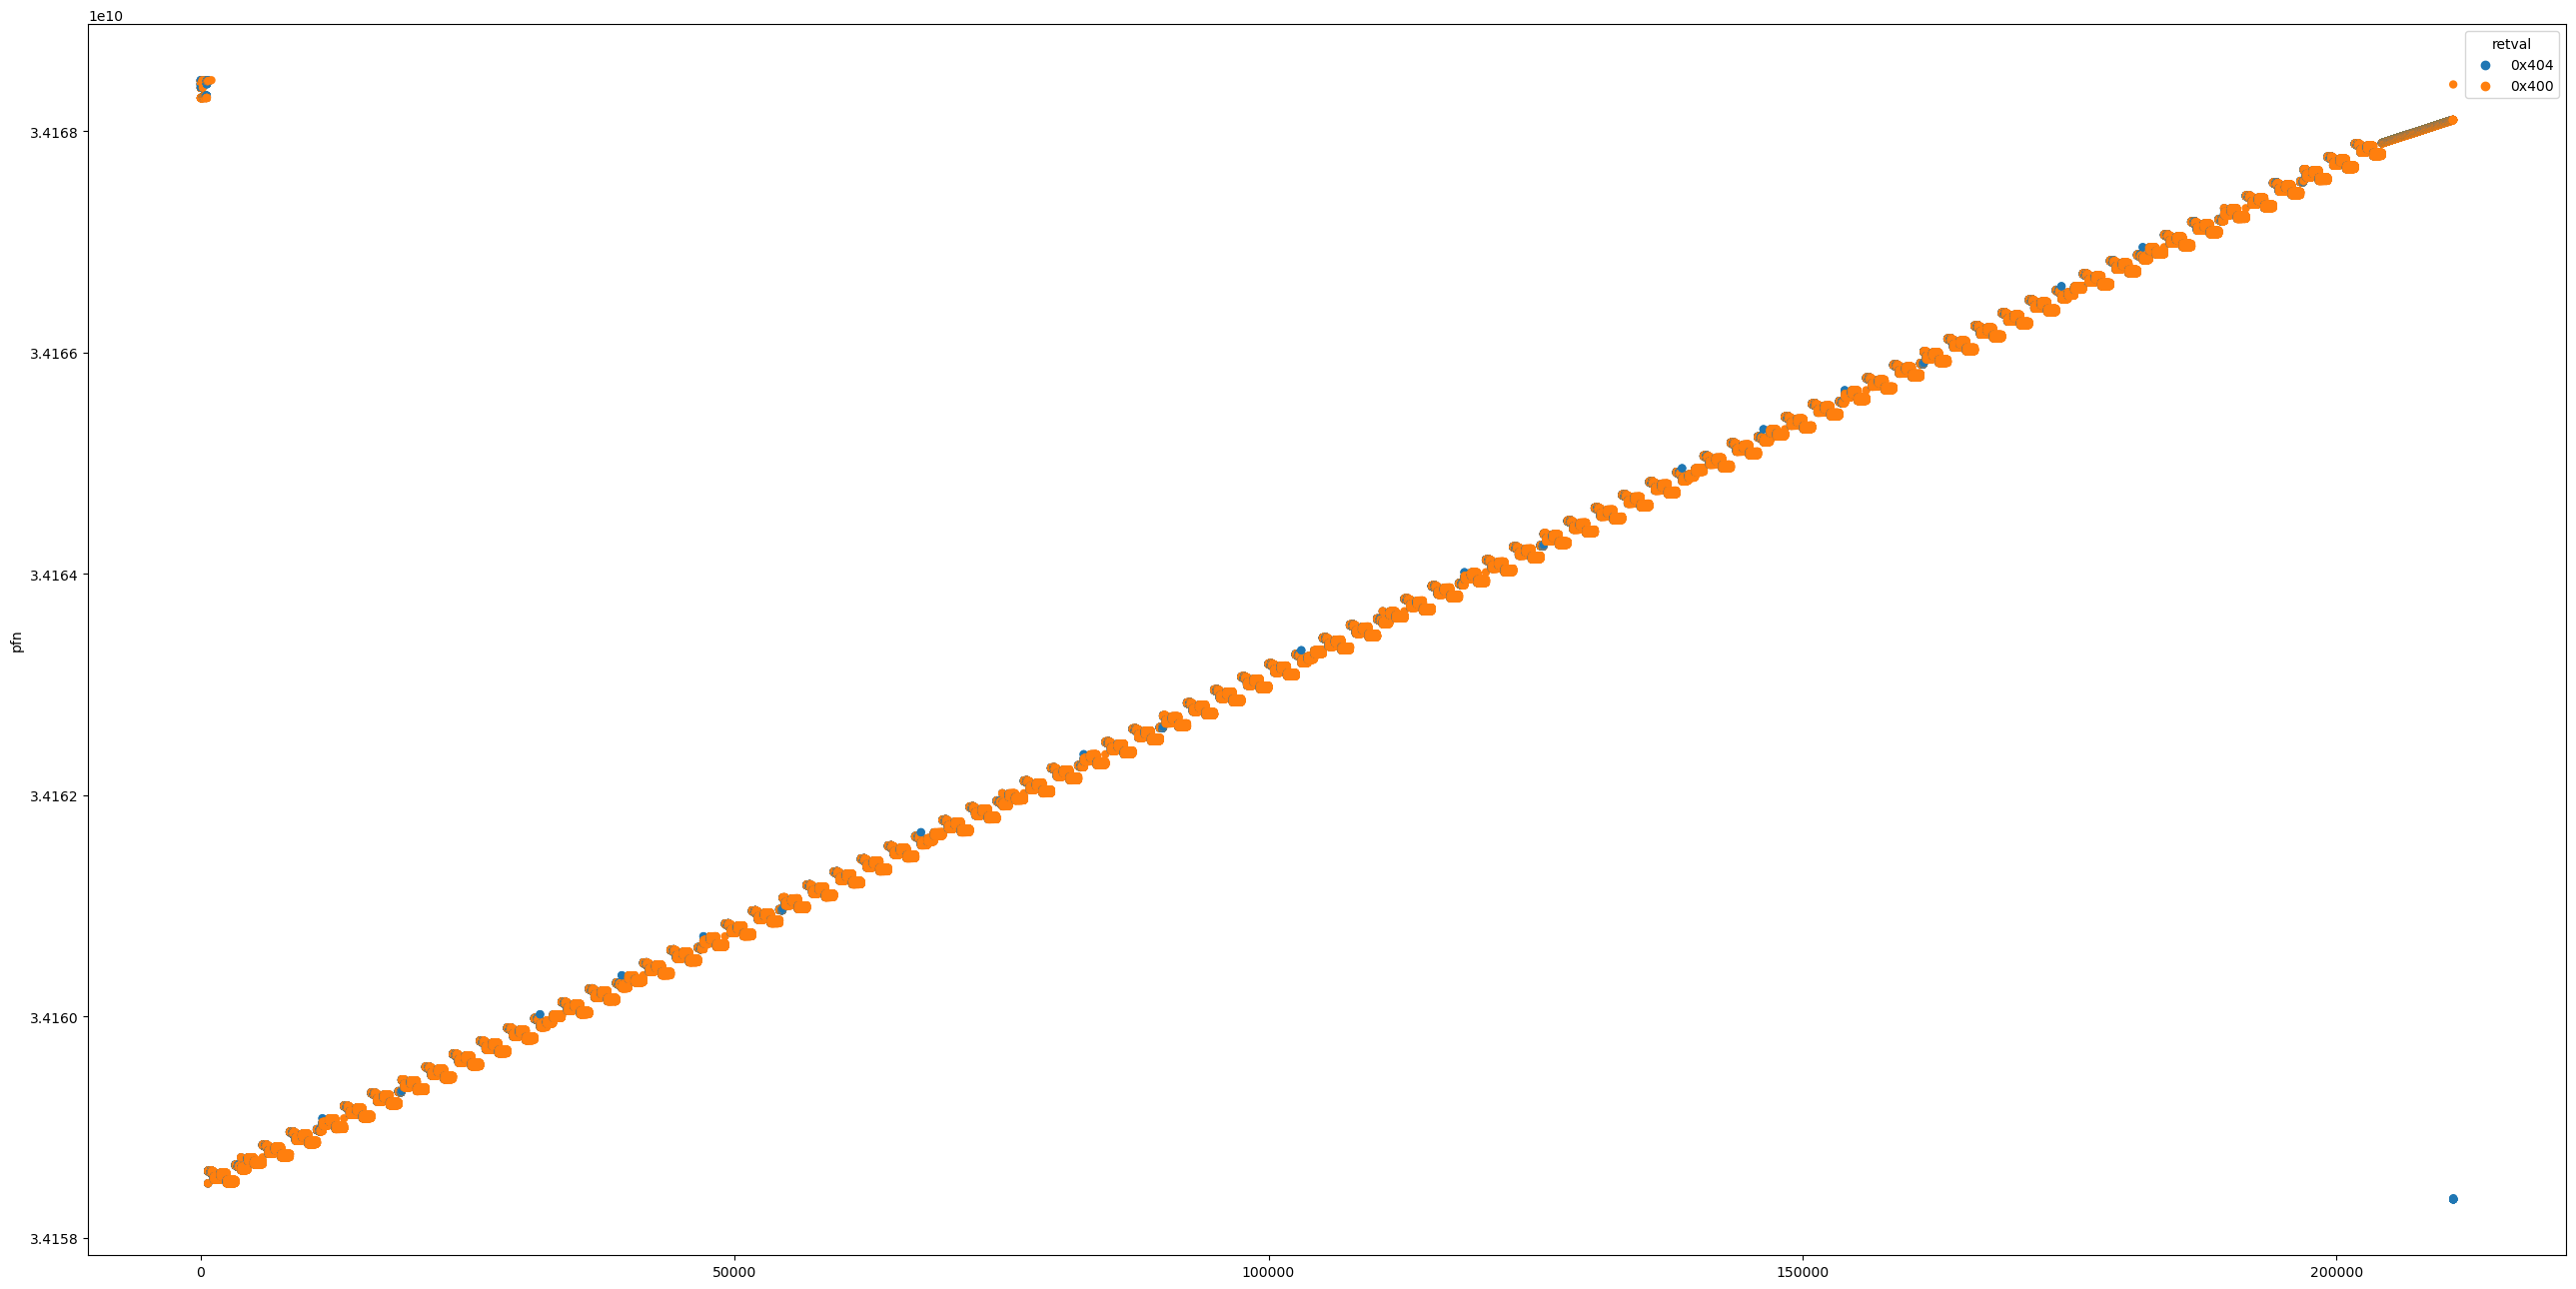

In [43]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(kernel_fault_major_df)), y=kernel_fault_major_df['pfn'], hue=kernel_fault_major_df["retval"], linewidth=0)

<Axes: ylabel='pfn'>

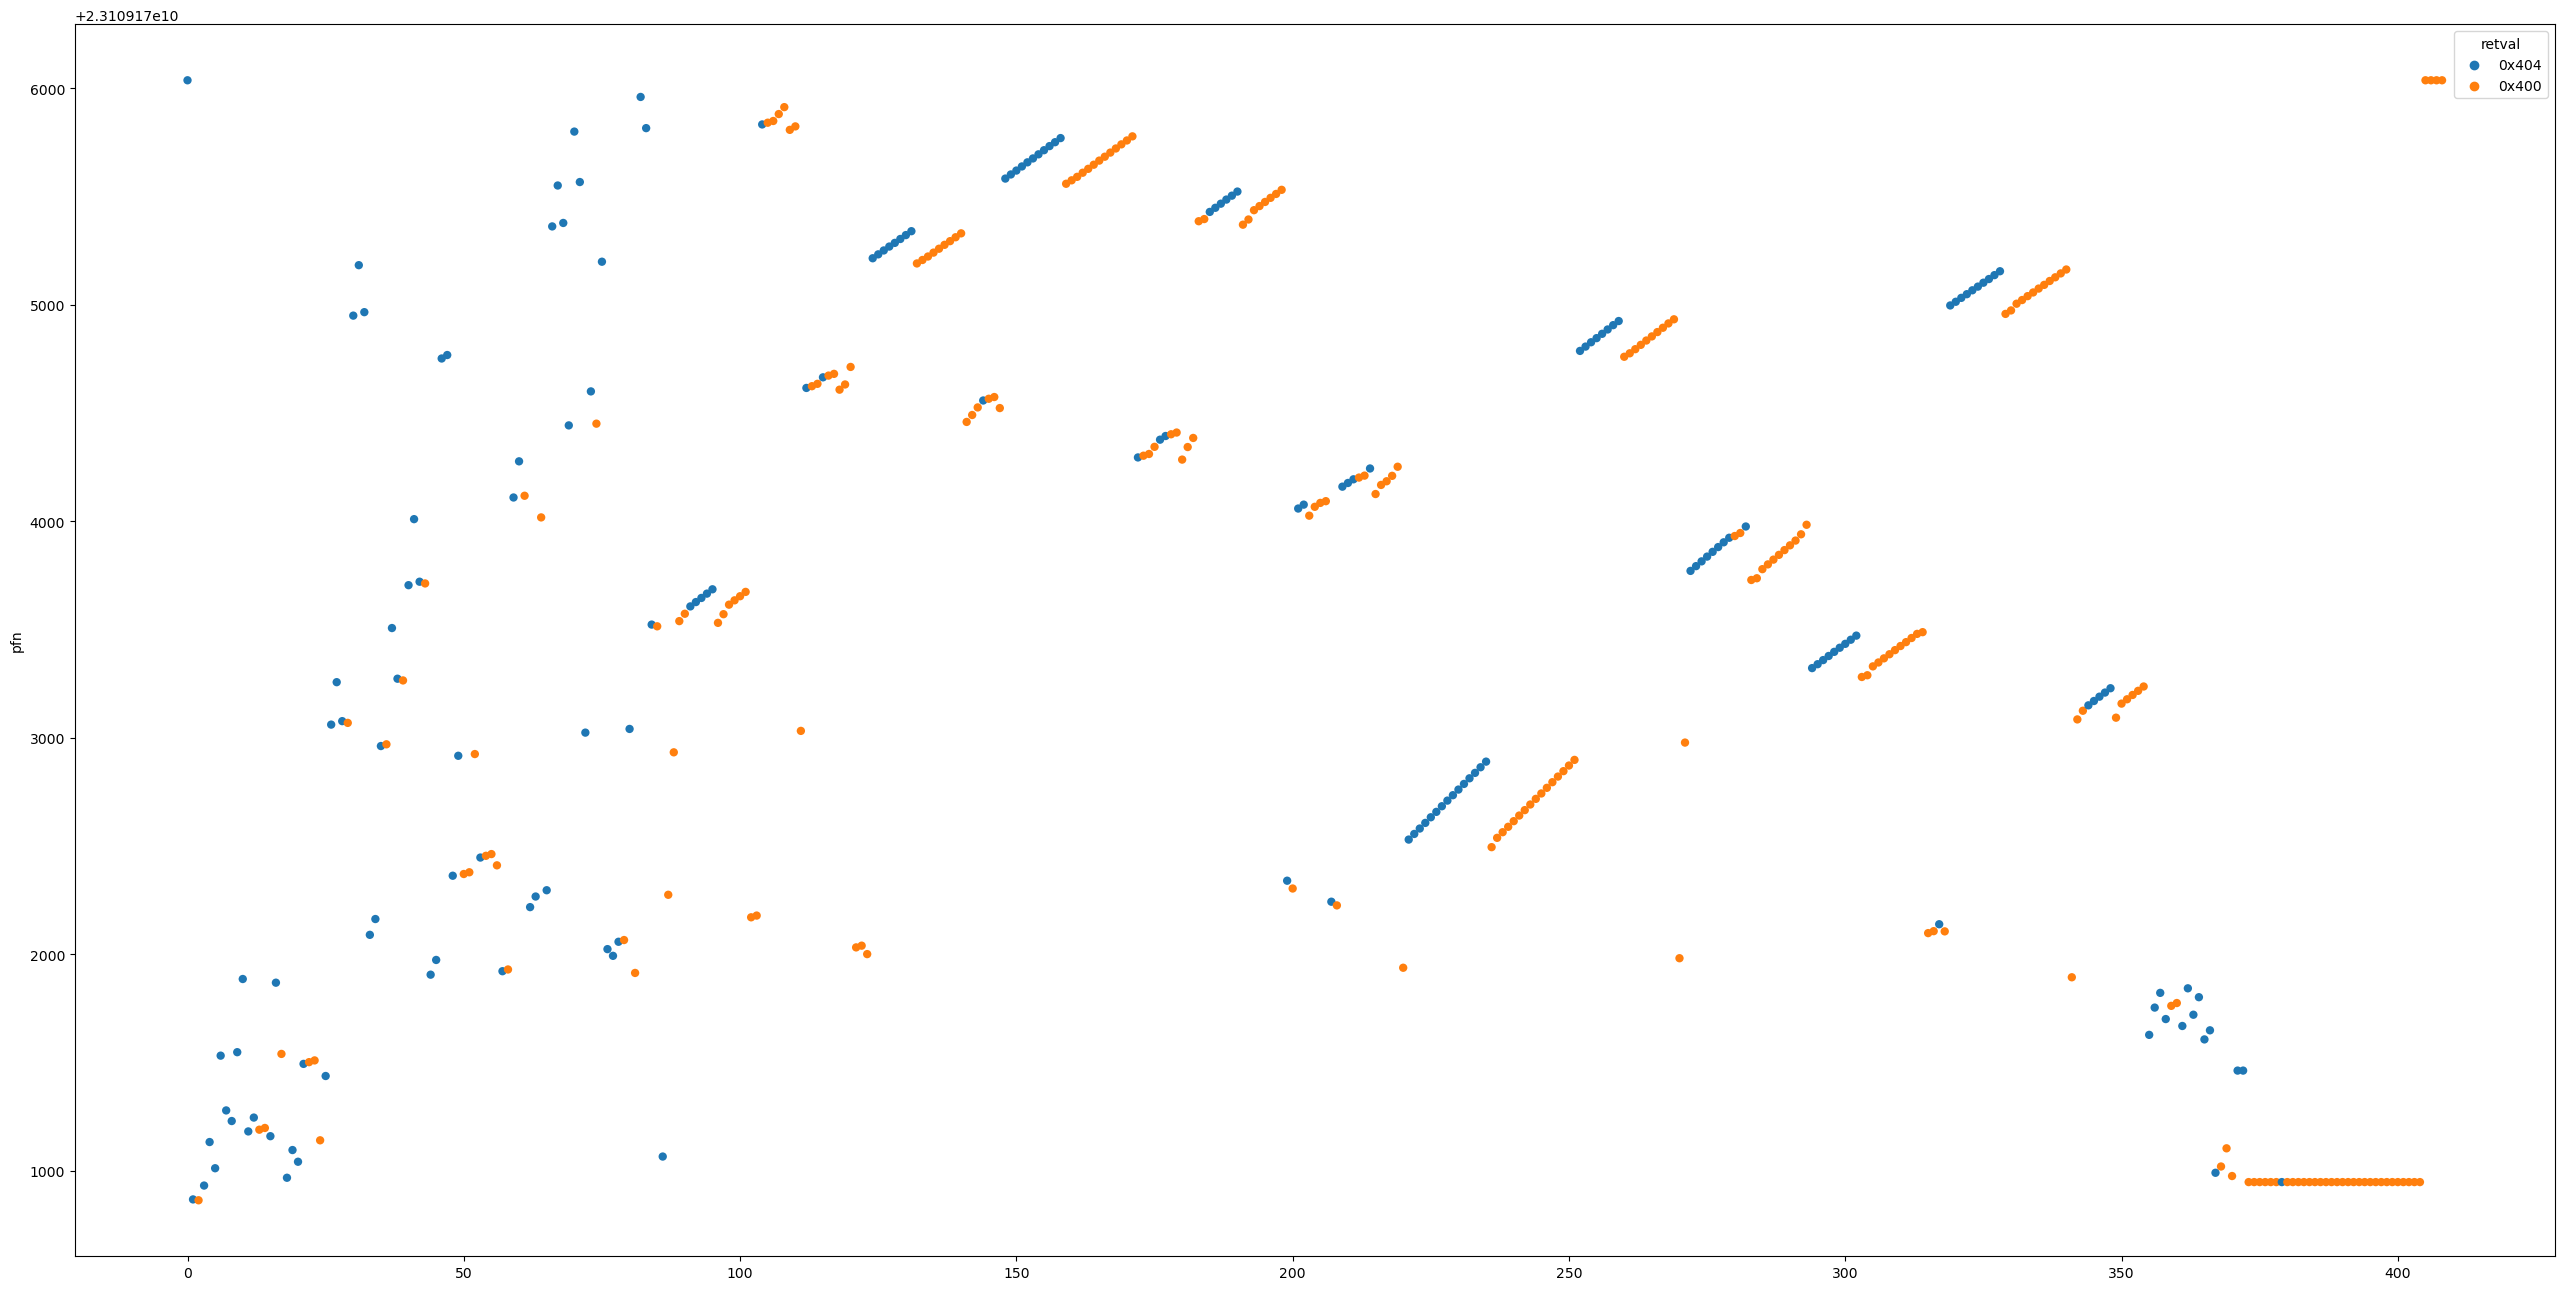

In [44]:
plt.figure(figsize=(32,16))
sns.scatterplot(x=range(len(user_fault_major_df)), y=user_fault_major_df['pfn'], hue=user_fault_major_df["retval"], linewidth=0)

In [45]:
fault_major_df["retval"].value_counts()

retval
0x400    191439
0x404     19917
Name: count, dtype: int64